In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO
import random

import pysam
import h5py

from Bio import motifs
from Bio import pairwise2
from Bio.Seq import Seq

In [2]:
import sys

sys.path.insert(0, "/home1/smaruj/akita_utils/")

# from akita_utils import *
import akita_utils

2022-07-17 18:05:40.025244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /spack/apps/linux-centos7-x86_64/gcc-8.3.0/python-3.9.2-uvcroioc4witkp6qf7mbebof5ix4wlb6/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/pmix-3.1.3-3sm6emyqaxapunh7rwbjvtaqoqe2e5z3/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openmpi-4.0.2-ipm3dnvlbtxawpi4ifz7jma6jgr7mexq/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openblas-0.3.8-2no6mfziiclwxb7lstxoos335gnhjpes/lib:/spack/apps/gcc/8.3.0/lib64::/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib
2022-07-17 18:05:40.025277: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
genome_open = pysam.Fastafile("/project/fudenber_735/genomes/mm10/mm10.fa")

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
print("Tensorflow: ", tf.__version__)

from basenji import dataset, seqnn, dna_io, stream

Tensorflow:  2.9.1


In [5]:
# NOTE
# head_i = 0 #human
# head_i = 1 #mouse
#

head_i = 1 #mouse
# head_i = 0
model_num = 1 #which fold to use


#base_dir = '/project/fudenber_735/backup/DNN_HiC/human-mouse_5-16-21/'
#model_dir = base_dir+"/f"+str(model_num)+"_c0/train/"

base_dir = "/project/fudenber_735/tensorflow_models/akita/v2/models/"
model_dir = base_dir + "/f" + str(model_num) + "c0/train/"
model_file  = model_dir + "/model" + str(head_i) + "_best.h5"


# model_dir = '/home1/fudenber/repositories/basenji/manuscripts/akita/'
# model_file = model_dir+'/model_best.h5'

params_file = model_dir + "/params.json"
# params_file -> json (dict) with model's parameters
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params["model"]
    params_train = params["train"]
seq_length = params_model["seq_length"]
params_model["verbose"] = False

seqnn_model = seqnn.SeqNN(params_model)
print("built")

seqnn_model.restore(model_file, head_i=head_i)    # model with the mouse head
print("restored")

print(seq_length)

2022-07-17 18:05:56.765397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /spack/apps/linux-centos7-x86_64/gcc-8.3.0/python-3.9.2-uvcroioc4witkp6qf7mbebof5ix4wlb6/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/pmix-3.1.3-3sm6emyqaxapunh7rwbjvtaqoqe2e5z3/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openmpi-4.0.2-ipm3dnvlbtxawpi4ifz7jma6jgr7mexq/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openblas-0.3.8-2no6mfziiclwxb7lstxoos335gnhjpes/lib:/spack/apps/gcc/8.3.0/lib64::/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib
2022-07-17 18:05:56.765429: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-17 18:05:56.765473: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b01-12.hpc.usc.edu): /pro

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 1310720, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 stochastic_reverse_complement   ((None, 1310720, 4)  0          ['sequence[0][0]']               
 (StochasticReverseComplement)  , ())                                                             
                                                                                                  
 stochastic_shift (StochasticSh  (None, 1310720, 4)  0           ['stochastic_reverse_complement[0
 ift)                                                            ][0]']                     

In [6]:
hic_diags = params_model["diagonal_offset"]
try:
    target_crop = params_model["trunk"][-2]["cropping"]
except:
    target_crop = params_model["target_crop"]

print("hic_diags: ", hic_diags) 
print("target_crop: ", target_crop)
print("seq_length: ", seq_length)

target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags) * ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size, 2)    # Return the indices for the upper-triangle of an (n, m) array, here k=2 (diagonal offset)
# target_map_size, target_length_cropped, triu_tup[0].shape

print("target_length_cropped: ", target_length_cropped)
print("target_map_size: ", target_map_size)
print("shape of triu_tup[0]: ", triu_tup[0].shape)

hic_diags:  2
target_crop:  64
seq_length:  1310720
target_length_cropped:  130305
target_map_size:  512
shape of triu_tup[0]:  (130305,)


In [7]:
background_file = base_dir + '../analysis/background_seqs.fa'
background_seqs = []
with open(background_file,'r') as f:
  for line in f.readlines():
    if '>' in line: continue
    background_seqs.append(dna_io.dna_1hot(line.strip())) 

In [8]:
len(background_seqs)

10

In [9]:
background_seqs = background_seqs[0:5]

In [10]:
len(background_seqs)

5

In [11]:
seq_coords_df = akita_utils.prepare_insertion_tsv(
    h5_dirs = '/project/fudenber_735/tensorflow_models/akita/v2/analysis/permute_boundaries_motifs_ctcf_mm10_model*/scd.h5',
    score_key = 'SCD',
    pad_flank = 0, #how much flanking sequence around the sites to include
    weak_thresh_pct = 1, # don't use sites weaker than this, might be artifacts
    weak_num = 2 ,
    strong_thresh_pct = 99, # don't use sites weaker than this, might be artifacts
    strong_num = 2 ,
    save_tsv=None, # optional filename to save a tsv
)

29 duplicates removed for  /project/fudenber_735/tensorflow_models/akita/v2/analysis/permute_boundaries_motifs_ctcf_mm10_model7/scd.h5
29 duplicates removed for  /project/fudenber_735/tensorflow_models/akita/v2/analysis/permute_boundaries_motifs_ctcf_mm10_model1/scd.h5
annotating each site with boundary-wide scores
filtering sites by overlap with rmsk
df prepared


In [ ]:
# padding = 20

In [ ]:
# num_inserts = 2
# one_side_radius = 100 
# spacer = one_side_radius - padding

In [ ]:
# motif_len = 19
# multi_insert_length = num_inserts * (motif_len + 2 * one_side_radius)
# print(multi_insert_length//num_inserts)

In [12]:
def _insul_diamond_central(mat, window=10):
    """calculate insulation in a diamond around the central pixel"""
    N = mat.shape[0]
    if window > N // 2:
        raise ValueError("window cannot be larger than matrix")
    mid = N // 2
    lo = max(0, mid + 1 - window)
    hi = min(mid + window, N)
    score = np.nanmean(mat[lo : (mid + 1), mid:hi])
    return score

In [13]:
def plot_for_target(predictions, target_map_size, hic_diags, seq_nr, padding, saving=False, size=5, target = 0, vlim = .5, window = 50):
    
    nr_bg = predictions.shape[0]
    bin_mid = target_map_size//2
    
    plt.figure(figsize=(size, 2*size*nr_bg))

    for i in range(nr_bg):
        insert_pred = predictions[i]

        plt.subplot(1, nr_bg, i+1)
        im = plt.matshow(
                akita_utils.from_upper_triu(  
                insert_pred[:,target], target_map_size, hic_diags),
                vmin=-1*vlim, vmax=vlim, fignum=False,cmap='RdBu_r')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.title('insert-scd: '+str(  np.sqrt( (insert_pred**2).sum(axis=0)  )[target] )
                 + '\n background: '+str(i)) 
    plt.tight_layout()
    if saving == True:
        plt.savefig(f"Seq-{seq_nr}_pad-{padding}.png")
    plt.show()
    

In [14]:

def multiple_padding(seq_coords_df, 
                     background_seqs, 
                     pad_list,
                     target_map_size, 
                     hic_diags,
                     head = 1, #mouse
                     orientation="same",
                     stat = ["SCD"],
                     verbose=True,
                     plotting=True,
                     saving=False, 
                     num_inserts=2, 
                     one_side_radius=100, 
                     motif_len=19):
    
    orientation_types = ["same", "convergent", "divergent"]
    if orientation not in orientation_types:
        raise ValueError("Invalid orientation. Expected one of: %s" % orientation_types)
    
    nr_seq = len(seq_coords_df)
    nr_bg = len(background_seqs)
    
    nr_targets = 6
    
    if head == 0:
        nr_targets = 5
    
    nr_pads = len(pad_list)
    
    multi_insert_length = num_inserts * (motif_len + 2 * one_side_radius)
    
    INS_windows = []
                
    for stat_matric in stat:
        if stat_matric[:3] == "INS":
            window = int(stat_matric.split("-")[1])
            INS_windows.append(window)
    
    INS_all_paddings = {}
    for window in INS_windows:
        INS_all_paddings[window] = np.zeros(shape=(nr_pads, nr_seq, nr_bg, nr_targets))
                
    # if "SCD" in stat_matric:
    SCD_all_paddings = np.zeros(shape=(nr_pads, nr_seq, nr_bg, nr_targets))
    
    for p in range(len(pad_list)):
        
        padding = pad_list[p]
        
        print(f"padding = {padding} || Started working on padding = {padding}")
        
        spacer = one_side_radius - padding
        
        offsets = []

        for i in range(num_inserts):
            offsets.append( seq_length//2 - multi_insert_length//2 + i * (multi_insert_length//2) + spacer)
        
        INS_all_sequences = {}
        for window in INS_windows:
            INS_all_sequences[window] = np.zeros(shape=(nr_seq, nr_bg, nr_targets))
                
        # if "SCD" in stat_matric:
        SCD_all_sequences = np.zeros(shape=(nr_seq, nr_bg, nr_targets))
        
        
        for i in seq_coords_df.index:      #iteraton over sequences
            
            all_inserts = []

            for bi in range(len(background_seqs)):
                seq_1hot = background_seqs[bi].copy()
                this_row = seq_coords_df.iloc[i]
                
                if orientation == "same":
                    seq_1hot_CTCF_pad_left = dna_io.dna_1hot(genome_open.fetch(this_row.chrom, this_row.start-padding, this_row.end+padding).upper())

                    if this_row.strand == '-': 
                        seq_1hot_CTCF_pad = dna_io.hot1_rc(seq_1hot_CTCF_pad_left)
                    
                    for offset in offsets:
                        seq_1hot[offset : offset + len(seq_1hot_CTCF_pad_left)] = seq_1hot_CTCF_pad_left
                    all_inserts.append(seq_1hot)
                
                elif orientation == "convergent":
                    seq_1hot_CTCF_pad_left = dna_io.dna_1hot(genome_open.fetch(this_row.chrom, this_row.start-padding, this_row.end+padding).upper())
                    
                    if this_row.strand == '-': 
                        seq_1hot_CTCF_pad_left = dna_io.hot1_rc(seq_1hot_CTCF_pad_left)
                    
                    seq_1hot_CTCF_pad_right = dna_io.hot1_rc(seq_1hot_CTCF_pad_left)
                    
                    for o in range(len(offsets)):
                        if o % 2 == 0:
                            seq_1hot[offsets[o] : offsets[o] + len(seq_1hot_CTCF_pad_left)] = seq_1hot_CTCF_pad_left
                        else:
                            seq_1hot[offsets[o] : offsets[o] + len(seq_1hot_CTCF_pad_right)] = seq_1hot_CTCF_pad_right
                    all_inserts.append(seq_1hot)
                    
                elif orientation == "divergent":
                    seq_1hot_CTCF_pad_right = dna_io.dna_1hot(genome_open.fetch(this_row.chrom, this_row.start-padding, this_row.end+padding).upper())
                    
                    if this_row.strand == '-': 
                        seq_1hot_CTCF_pad_right = dna_io.hot1_rc(seq_1hot_CTCF_pad_right)

                    seq_1hot_CTCF_pad_left = dna_io.hot1_rc(seq_1hot_CTCF_pad_right)
                    
                    for o in range(len(offsets)):
                        if o % 2 == 0:
                            seq_1hot[offsets[o] : offsets[o] + len(seq_1hot_CTCF_pad_left)] = seq_1hot_CTCF_pad_left
                        else:
                            seq_1hot[offsets[o] : offsets[o] + len(seq_1hot_CTCF_pad_right)] = seq_1hot_CTCF_pad_right
                    all_inserts.append(seq_1hot)

            all_inserts = np.array(all_inserts) 

            # print(all_inserts.shape) 

            pred = seqnn_model.predict(all_inserts, batch_size=10)  

            # print(pred.shape) 
            
            INS_all_backgrounds = {}
            for window in INS_windows:
                INS_all_backgrounds[window] = np.zeros(shape=(nr_bg, nr_targets))
                
            # if "SCD" in stat_matric:
            SCD_all_backgrounds = np.zeros(shape=(nr_bg, nr_targets))
            
            
            for bi in range(nr_bg):      # iteration over background sequences
                
                insert_pred = pred[bi]
                
                if verbose == True:
                
                    print("\n**********")
                    print("Padding: ", padding, "\nSequence: ", i, "\nBackground: ", bi, "\nSCD averaged over targets: ", np.sqrt( (insert_pred**2).sum(axis=0)  ).mean())
                    print("**********\n")

                    print("Metrics: ")
                                                
                INS_all_targets = {}
                for window in INS_windows:
                    INS_all_targets[window] = np.zeros(insert_pred.shape[1])
                
                # if "SCD" in stat_matric:
                SCD_all_targets = np.zeros(insert_pred.shape[1])
                
                for target_ind in range(insert_pred.shape[1]):       # iteration over targets

                    # print(target_ind, "SCD: ", np.sqrt( (insert_pred**2).sum(axis=0))[target_ind])
                    
                    INS_dict = {}
                    mat = akita_utils.from_upper_triu(insert_pred[:,target_ind], target_map_size, hic_diags)
                    
                    for stat_matric in stat:
                                            
                        if stat_matric == "SCD":
                    
                            SCD = np.sqrt( (insert_pred**2).sum(axis=0))[target_ind]      # sequence = i background = bi, target = target_ind
                            SCD_all_targets[target_ind] = SCD
                            
                            if verbose == True:
                                print("target_ind: ", target_ind, "SCD: ", np.sqrt( (insert_pred**2).sum(axis=0))[target_ind])
                        
                        elif stat_matric[:3] == "INS":
                            
                            window = int(stat_matric.split("-")[1])
                            
                            INS_all_targets[window][target_ind] = _insul_diamond_central(mat, window=window)
                            
                            if verbose == True:
                                print("target_ind: ", target_ind, f"INS-{window}: ", INS_all_targets[window][target_ind])
                
                # print(SCD_all_targets)
                # print(INS_all_targets)
                
                for window in INS_windows:
                    INS_all_backgrounds[window][bi] = INS_all_targets[window]
                
                SCD_all_backgrounds[bi] = SCD_all_targets
                
            print(f"padding = {padding} || Plotting")
            
            if plotting == True:
                
                for target_i in range(pred.shape[2]):
                    print(target_i)
                    plot_for_target(pred, target_map_size=target_map_size, hic_diags=hic_diags, seq_nr=i, padding=padding, size=15, target=target_i)
                    
                    if saving == True:
                        plot_for_target(pred, target_map_size=target_map_size, hic_diags=hic_diags, seq_nr=i, padding=padding, saving=True, size=15, target=target_i)
                                    
            # print(SCD_all_backgrounds)
            # for window in INS_windows:
            #     print(INS_all_backgrounds[window])
            
            for window in INS_windows:
                INS_all_sequences[window][i] = INS_all_backgrounds[window]
                
            SCD_all_sequences[i] = SCD_all_backgrounds
                
        # print("INS_all_sequences ", INS_all_sequences)
        # print("SCD_all_sequences ", SCD_all_sequences)
        
        
        for window in INS_windows:
            INS_all_paddings[window][p] = INS_all_sequences[window]
                
        SCD_all_paddings[p] = SCD_all_sequences
        
    # print(SCD_all_paddings.shape)
    # for window in INS_windows:
    #     print(INS_all_paddings[window].shape)
    
    return(SCD_all_paddings, INS_all_paddings)
    
                    # print(seq_1hot[655241:655241+19] == seq_1hot[655260:655260+19])
            # all_inserts = np.append(all_inserts)
        
#         elif orientation == "convergent":
#             for background_seq in background_seqs:
#                 for i in seq_coords_df.index:
#                     seq_1hot = background_seq.copy()
#                     this_row = seq_coords_df.iloc[i]
#                     seq_1hot_CTCF_pad_left = dna_io.dna_1hot(genome_open.fetch(this_row.chrom, this_row.start-padding, this_row.end+padding).upper())
#                     if this_row.strand == '-': 
#                         seq_1hot_CTCF_pad_left = dna_io.hot1_rc(seq_1hot_CTCF_pad_left)
#                     # print(this_row.strand, Seq(genome_open.fetch(this_row.chrom, this_row.start-padding, this_row.end+padding).upper()))
#                     seq_1hot_CTCF_pad_right = dna_io.hot1_rc(seq_1hot_CTCF_pad_left)
#                     for o in range(len(offsets)):
#                         if o % 2 == 0:
#                             seq_1hot[offsets[o] : offsets[o] + len(seq_1hot_CTCF_pad_left)] = seq_1hot_CTCF_pad_left
#                         else:
#                             seq_1hot[offsets[o] : offsets[o] + len(seq_1hot_CTCF_pad_right)] = seq_1hot_CTCF_pad_right
#                     all_inserts.append(seq_1hot)
#                     # print(seq_1hot[655241:655241+19] == seq_1hot[655260:655260+19])
#             all_inserts = np.array(all_inserts) 
        
#         elif orientation == "divergent":
#             for background_seq in background_seqs:
#                 for i in seq_coords_df.index:
#                     seq_1hot = background_seq.copy()
#                     this_row = seq_coords_df.iloc[i]
#                     seq_1hot_CTCF_pad_left = dna_io.dna_1hot(genome_open.fetch(this_row.chrom, this_row.start-padding, this_row.end+padding).upper())
#                     if this_row.strand == '-': 
#                         seq_1hot_CTCF_pad_left = dna_io.hot1_rc(seq_1hot_CTCF_pad_left)
#                     # print(this_row.strand, Seq(genome_open.fetch(this_row.chrom, this_row.start-padding, this_row.end+padding).upper()))
#                     seq_1hot_CTCF_pad_right = dna_io.hot1_rc(seq_1hot_CTCF_pad_left)
#                     for o in range(len(offsets)):
#                         if o % 2 == 0:
#                             seq_1hot[offsets[o] : offsets[o] + len(seq_1hot_CTCF_pad_left)] = seq_1hot_CTCF_pad_left
#                         else:
#                             seq_1hot[offsets[o] : offsets[o] + len(seq_1hot_CTCF_pad_right)] = seq_1hot_CTCF_pad_right
#                     all_inserts.append(seq_1hot)
#                     # print(seq_1hot[655241:655241+19] == seq_1hot[655260:655260+19])
#             all_inserts = np.array(all_inserts) 
            
            
        # print(len(all_inserts[0]))
#         print(f"padding = {padding} || Prediction")
#         pred = seqnn_model.predict(all_inserts, batch_size=10)

#         scd_score = []

        # plt.figure(figsize=(8*3,5*3))
        
#         if plotting == True:
            
#             plt.figure(figsize=(8*3,5*3))
            
#             print(f"padding = {padding} || Plotting")
            
#             target_ind = 0
#             vlim = .5
#             bin_mid = target_map_size//2
#             window = 50
#             for i in range(40):
#                 insert_pred = pred[i]

#                 plt.subplot(8,5, i+1)
#                 im = plt.matshow(
#                         akita_utils.from_upper_triu(  
#                         insert_pred[:,target_ind], target_map_size,hic_diags),
#                         vmin=-1*vlim, vmax=vlim, fignum=False,cmap='RdBu_r')
#                 plt.colorbar(im, fraction=0.046, pad=0.04)
#                 plt.title('insert-scd: '+str(  np.sqrt( (insert_pred**2).sum(axis=0)  ).mean() ) 
#                           ) 
#                 #plt.axis([ bin_mid  - window,bin_mid+window,bin_mid-window, bin_mid+window])
#             plt.tight_layout()
#             # plt.savefig(f"Padding_{padding}_{orientation}.png")
#             plt.show()
        
#         print(f"padding = {padding} || SCD Calculation")
#         for i in range(nr_seq * nr_bg):
#             insert_pred = pred[i]
#             # print(i, np.sqrt( (insert_pred**2).sum(axis=0)))
#             scd_score.append(np.sqrt( (insert_pred**2).sum(axis=0)  ).mean())
        
#         np_scd_score = np.array(scd_score)
#         reshaped_scd_score = np_scd_score.reshape((nr_bg, nr_seq))
#         # seq_coords_df[f"Pad_{padding}_SCD"] = scd_score
        
#         for bs in range(len(background_seqs)):
#             seq_coords_df[f"Pad_{padding}_b{bs}_SCD"] = reshaped_scd_score[bs, :]
        
#     return seq_coords_df


In [15]:
pad_list = [k for k in range(0, 2)]

padding = 0 || Started working on padding = 0
1/1 [==============================] - 5s 5s/step
padding = 0 || Plotting
0


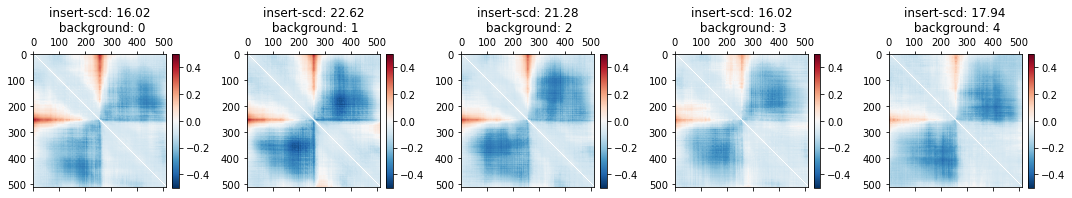

1


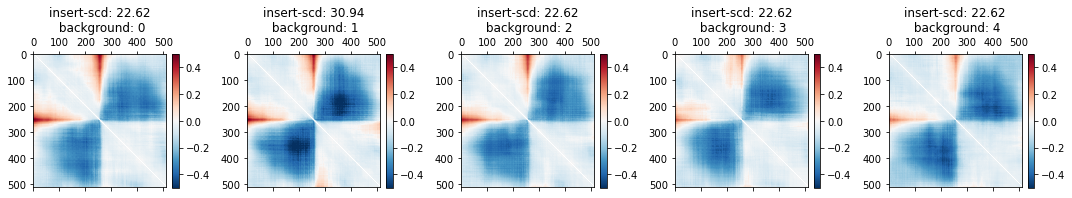

2


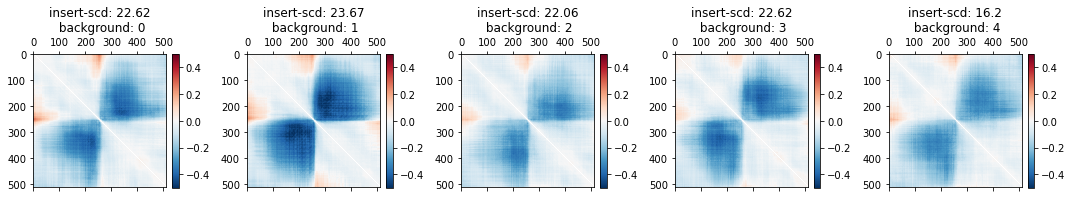

3


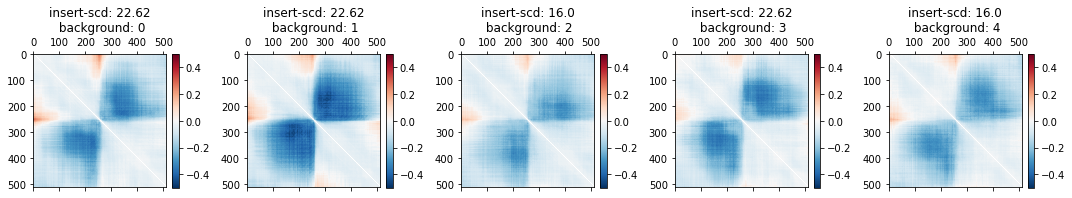

4


5


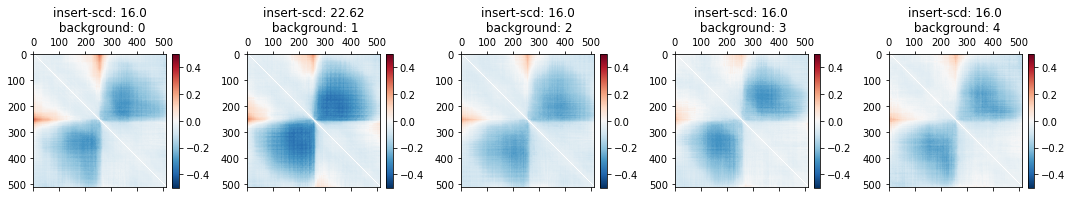

1/1 [==============================] - 4s 4s/step
padding = 0 || Plotting
0


1


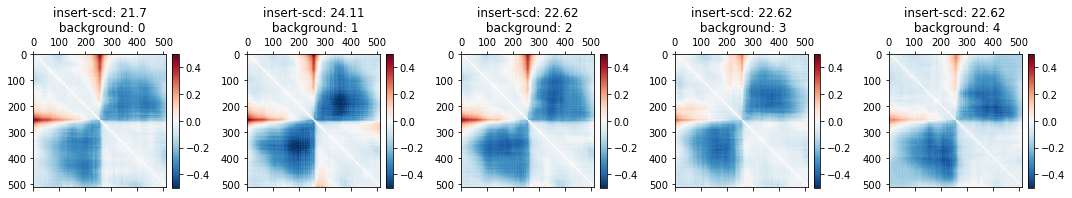

2


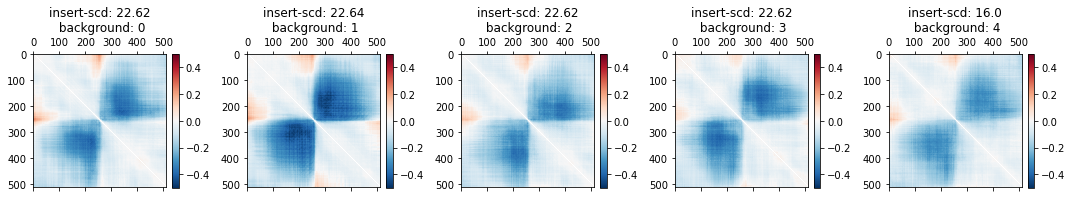

3


4


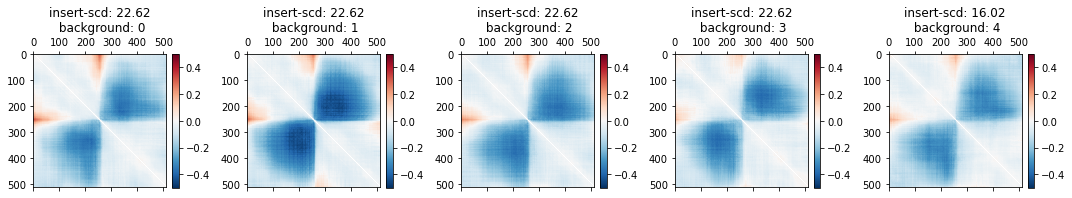

5


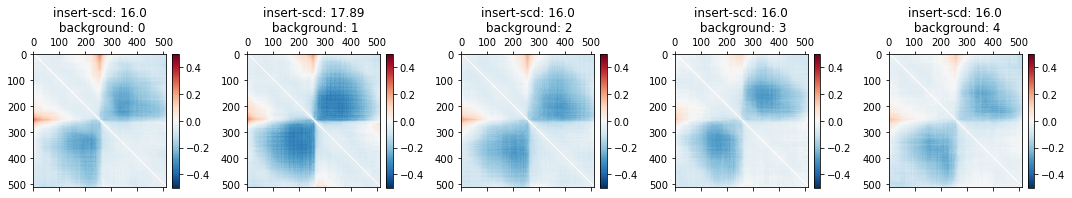

1/1 [==============================] - 4s 4s/step
padding = 0 || Plotting
0


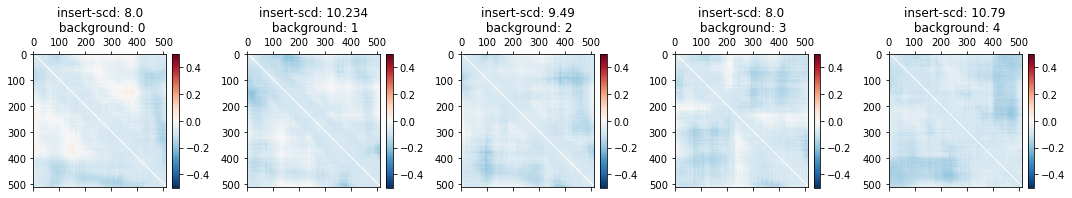

1


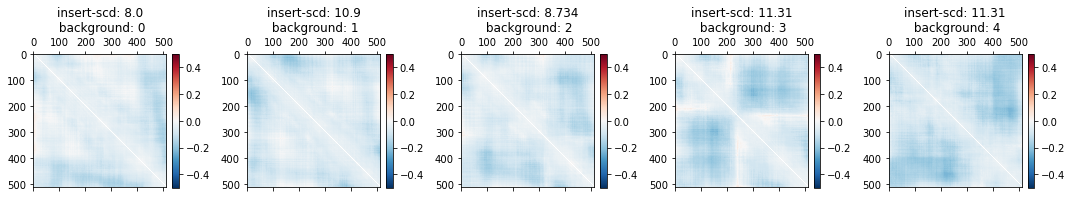

2


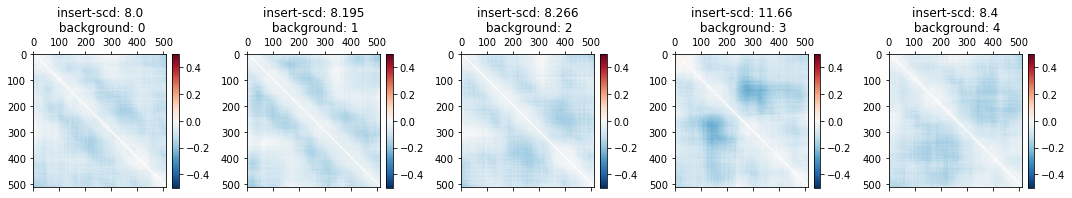

3


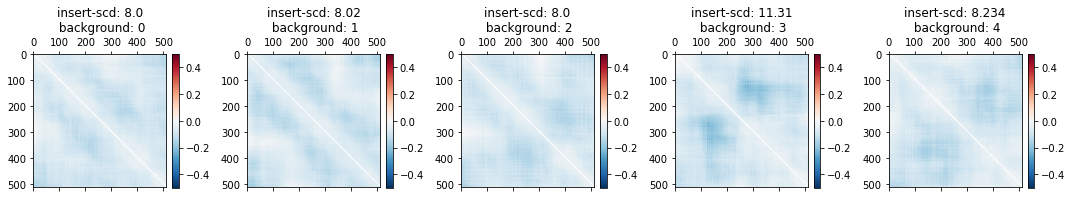

4


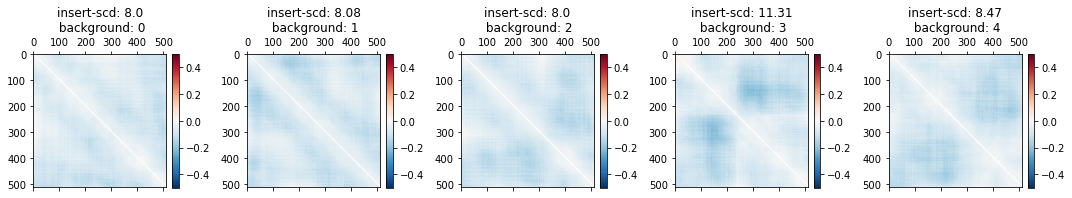

5


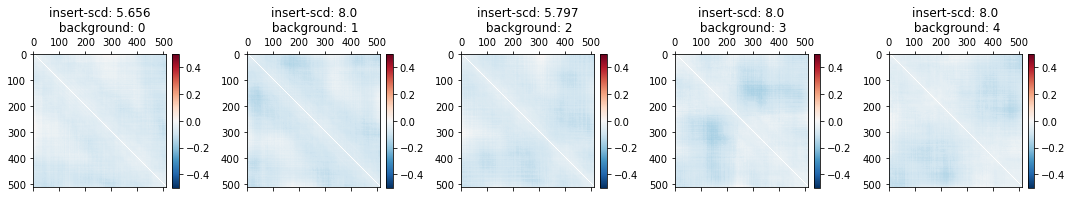

1/1 [==============================] - 4s 4s/step
padding = 0 || Plotting
0


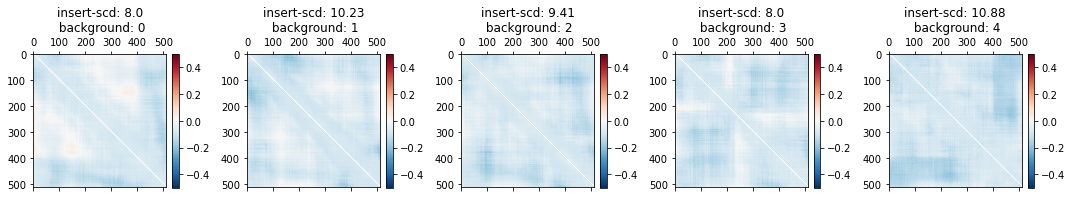

1


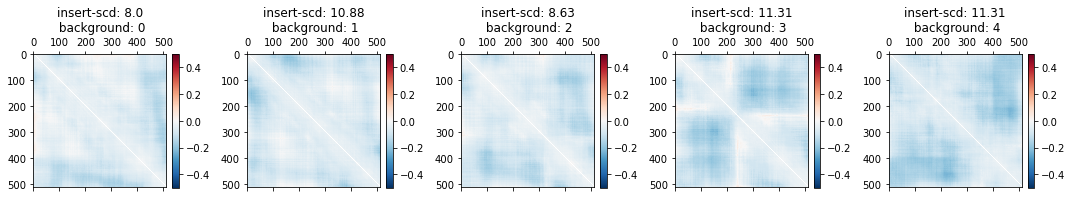

2


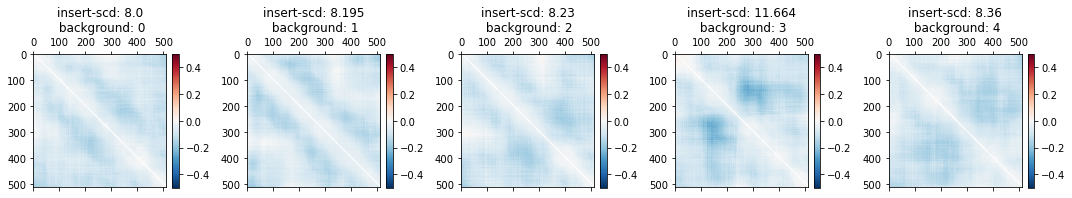

3


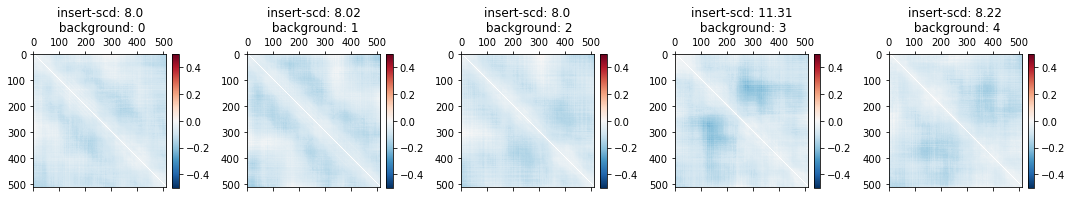

4


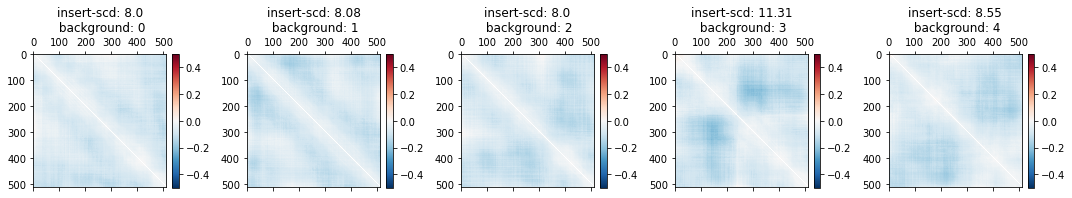

5


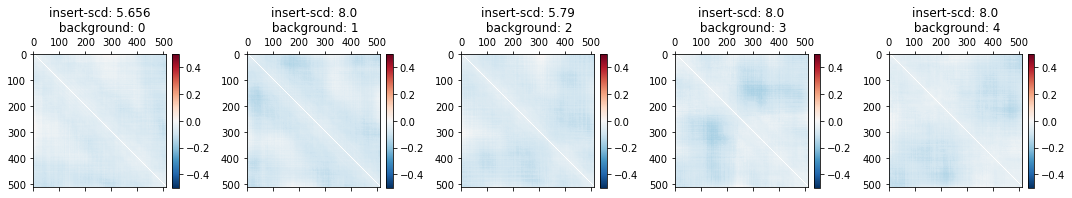

padding = 1 || Started working on padding = 1
1/1 [==============================] - 4s 4s/step
padding = 1 || Plotting
0


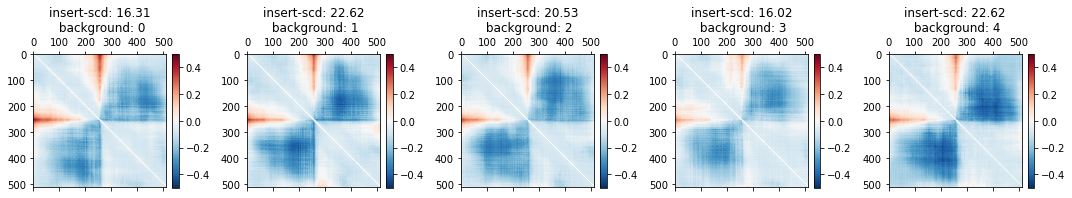

1


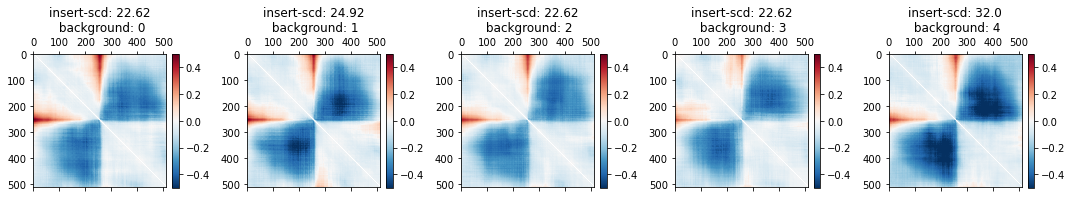

2


3


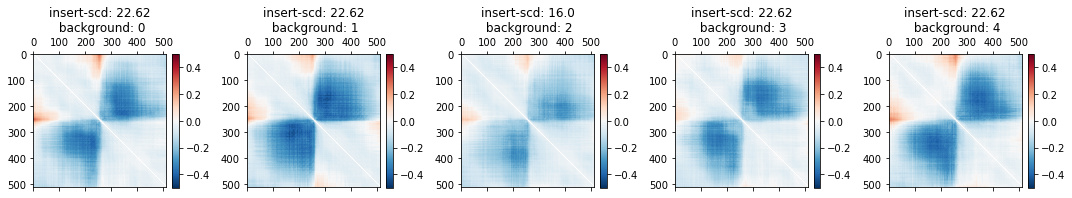

4


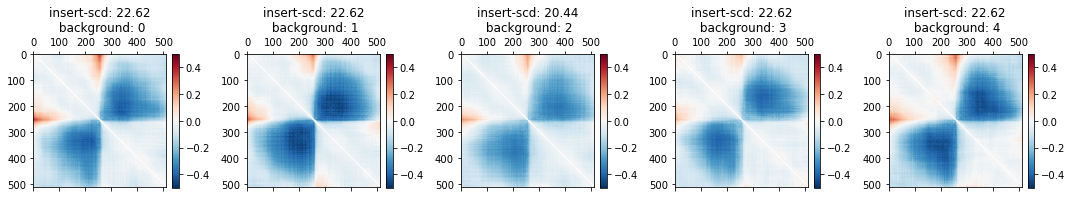

5


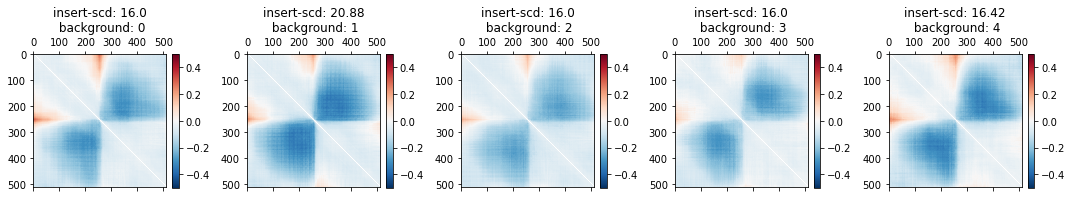

1/1 [==============================] - 4s 4s/step
padding = 1 || Plotting
0


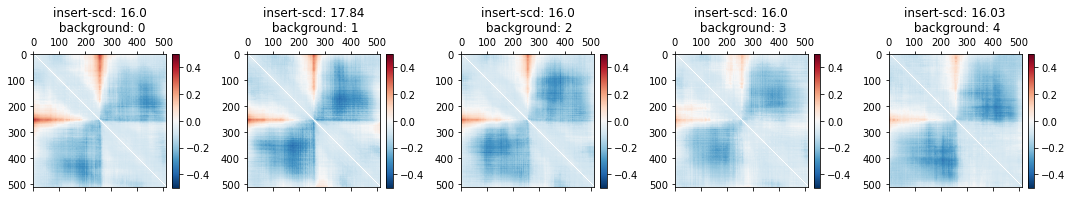

1


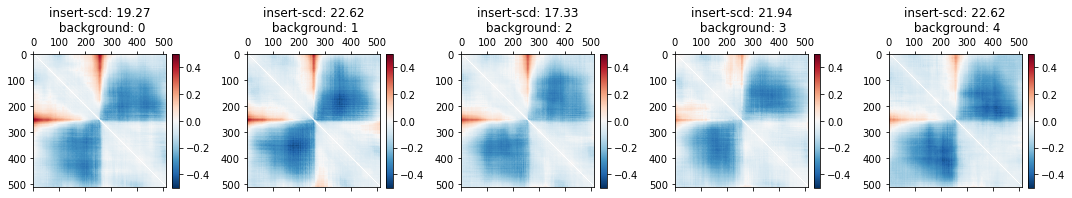

2


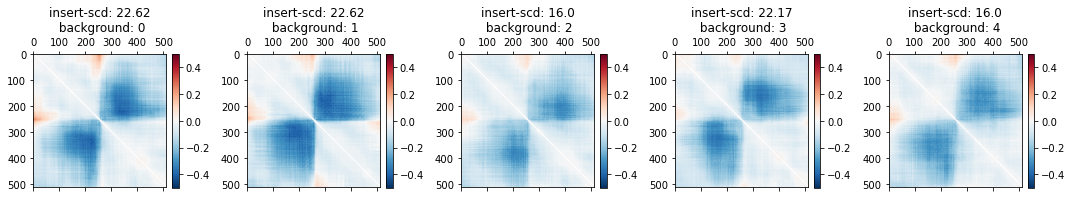

3


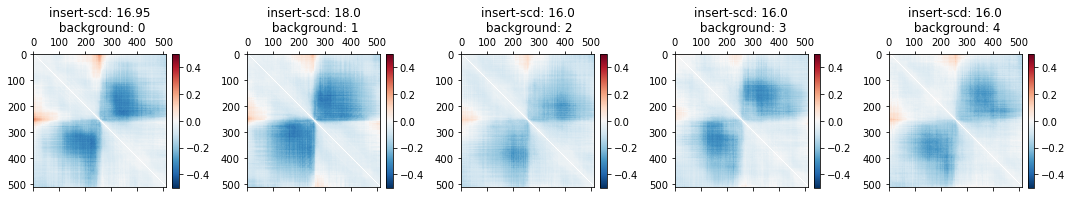

4


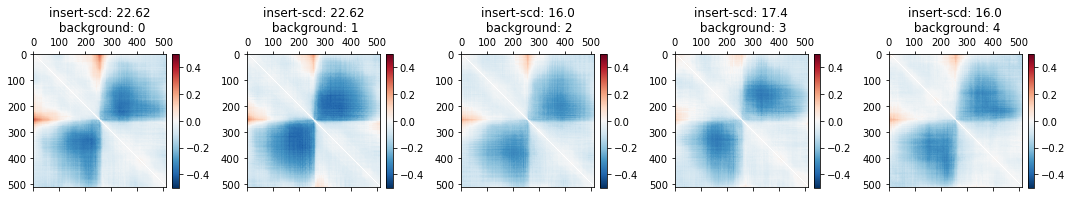

5


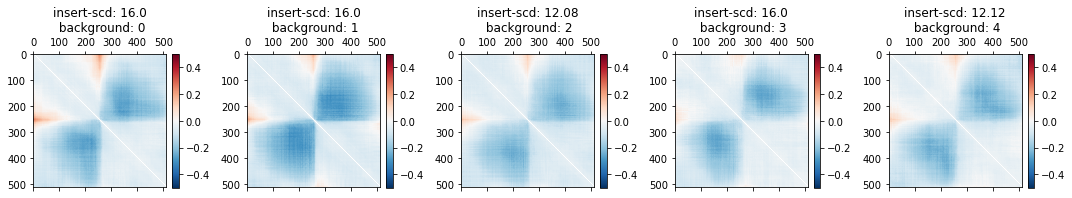

1/1 [==============================] - 4s 4s/step
padding = 1 || Plotting
0


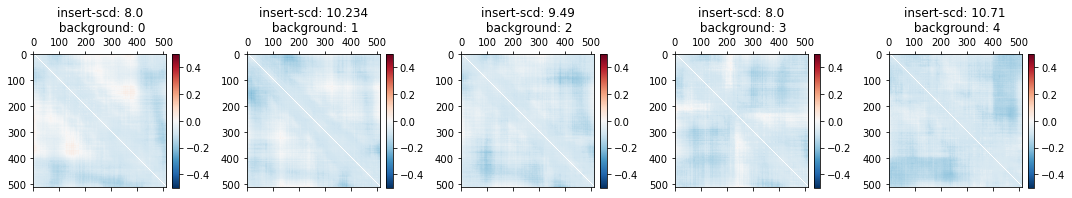

1


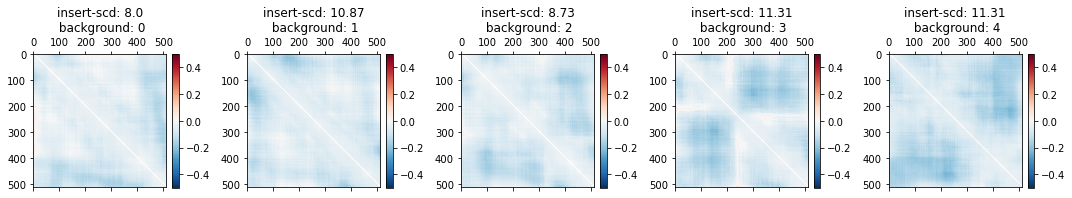

2


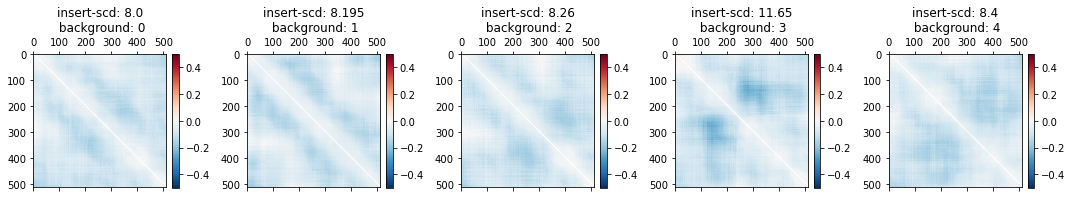

3


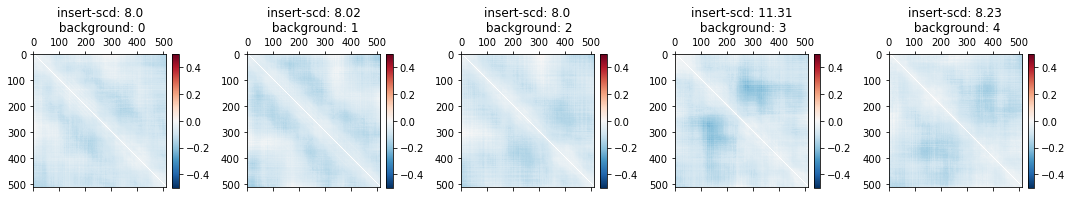

4


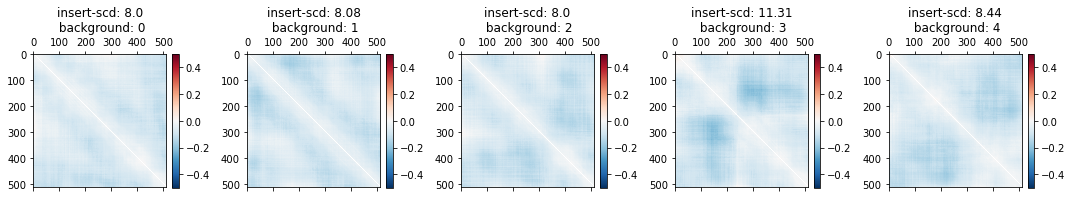

5


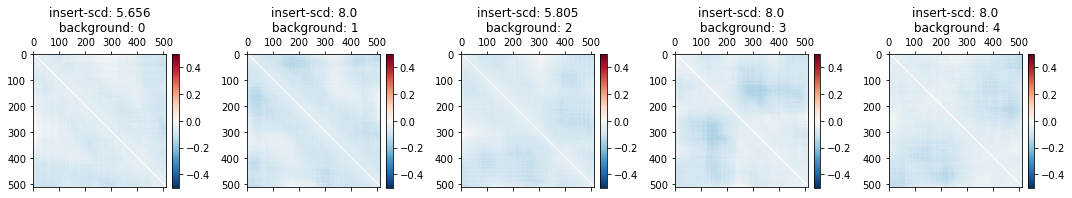

1/1 [==============================] - 4s 4s/step
padding = 1 || Plotting
0


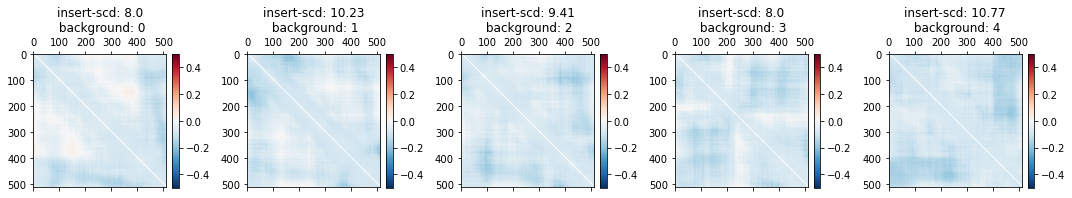

1


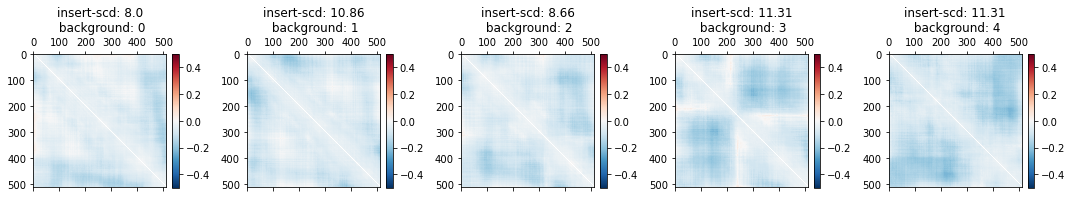

2


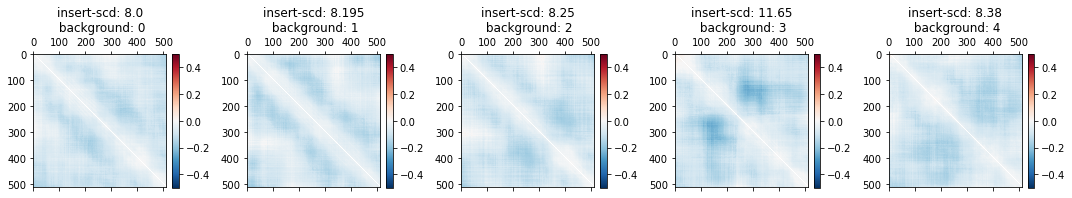

3


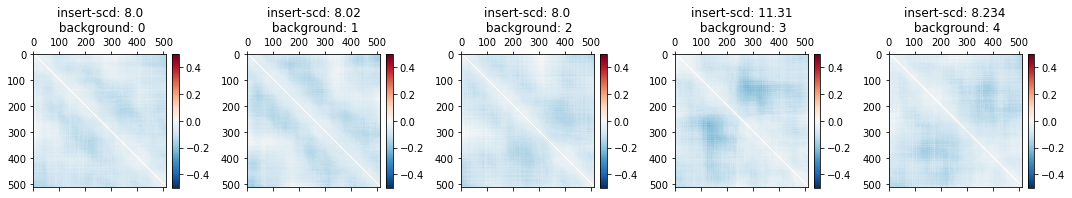

4


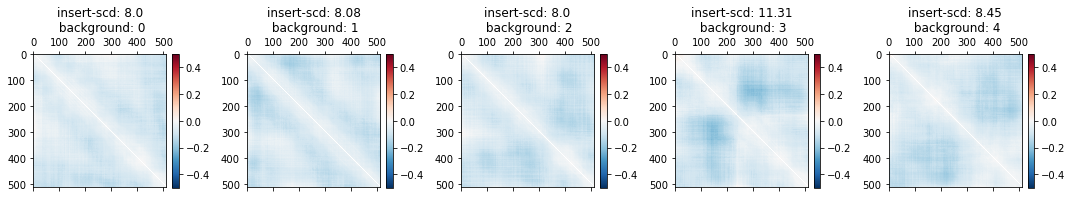

5


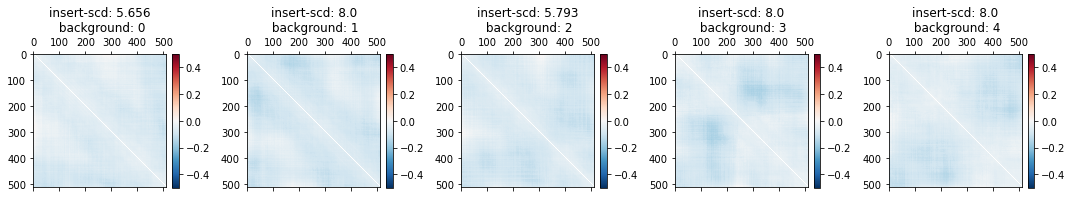

In [16]:
duap = multiple_padding(seq_coords_df, background_seqs, pad_list, target_map_size, hic_diags, 
                 head = 1,
                 orientation = "same", 
                 stat = ["SCD", "INS-16", "INS-20"],
                 verbose=False,
                 plotting=True,
                 num_inserts=2, 
                 one_side_radius=100, 
                 motif_len=19)

In [17]:
duap[0].shape
# 1st dim - numer of paddings tested
# 2nd dim - number of sequences
# 3rd dim - number of bINSackground sequences
# 4th dim - number of targets

(2, 4, 5, 6)

In [18]:
duap[1][16].shape

(2, 4, 5, 6)

In [ ]:
# seq_coords_df.to_csv("./50-60pads_divergent.csv", index=False)

In [45]:
def save_h5(seq_coords_df, out_dir, filename, stat, prediction):
    chrom = seq_coords_df.chrom.to_numpy()
    start = seq_coords_df.start.to_numpy().astype(np.int32)
    end = seq_coords_df.end.to_numpy().astype(np.int32)
    strand = seq_coords_df.strand.to_numpy()
    genSCD = seq_coords_df.genomic_SCD.to_numpy().astype(np.float64)
    
    with h5py.File(out_dir + "/" + filename, "w") as hf:
        hf.create_dataset("SCD",  data=prediction[0])
        for key in prediction[1]:
            hf.create_dataset("INS-" + str(key),  data=prediction[1][key])
        hf.create_dataset("Chromosome",  data=chrom.astype('S'))
        hf.create_dataset("Start",  data=start)
        hf.create_dataset("End",  data=end)
        hf.create_dataset("Strand",  data=strand.astype('S'))
        hf.create_dataset("genomic_SCD",  data=genSCD)

In [ ]:
save_h5(seq_coords_df=seq_coords_df, 
        out_dir=".", 
        filename="test.h5", 
        stat=["SCD", "INS-16", "INS-20"], 
        prediction=duap)

In [43]:
import h5py

with h5py.File('test.h5', 'w') as hf:
    hf.create_dataset("SCD",  data=duap[0])
    for key in duap[1]:
        hf.create_dataset("INS-" + str(key),  data=duap[0])
    hf.create_dataset("Chromosome",  data=chrom.astype('S'))
    hf.create_dataset("Start",  data=start)
    hf.create_dataset("End",  data=end)
    hf.create_dataset("Strand",  data=strand.astype('S'))
    hf.create_dataset("genomic_SCD",  data=genSCD)

In [ ]:
# offsets = []

# print(seq_length//2)
# print(seq_length//2 - multi_insert_length//2)
# for i in range(num_inserts):
#     offsets.append( seq_length//2 - multi_insert_length//2 + i * (multi_insert_length//2) + spacer)
# print(offsets)

In [ ]:
# all_inserts = []

# # inserting only to the first background sequence
# for background_seq in background_seqs:
#     for i in seq_coords_df.index:
#         seq_1hot = background_seq.copy()
#         this_row = seq_coords_df.iloc[i]
#         seq_1hot_CTCF_pad = dna_io.dna_1hot(genome_open.fetch(this_row.chrom, this_row.start-padding, this_row.end+padding).upper())
#         if this_row.strand == '-': 
#             seq_1hot_CTCF_pad = dna_io.hot1_rc(seq_1hot_CTCF_pad)
#         # print(this_row.strand, Seq(genome_open.fetch(this_row.chrom, this_row.start-padding, this_row.end+padding).upper()))
#         for offset in offsets:
#             seq_1hot[offset : offset + len(seq_1hot_CTCF_pad)] = seq_1hot_CTCF_pad
#         all_inserts.append(seq_1hot)
#         # print(seq_1hot[655241:655241+19] == seq_1hot[655260:655260+19])
# all_inserts = np.array(all_inserts)

In [ ]:
# all_inserts.shape

In [ ]:
# pred = seqnn_model.predict(all_inserts, batch_size=10)

In [ ]:
# pred.shape

In [ ]:
# scd_score = []

In [ ]:
# plt.figure(figsize=(8*3,5*3))

# target_ind = 0
# vlim = .5
# bin_mid = target_map_size//2
# window = 50
# for i in range(40):
#     insert_pred = pred[i]
#     print(i, np.sqrt( (insert_pred**2).sum(axis=0)))
#     scd_score.append(np.sqrt( (insert_pred**2).sum(axis=0)  ).mean())
    
#     plt.subplot(8,5, i+1)
#     im = plt.matshow(
#             akita_utils.from_upper_triu(  
#             insert_pred[:,target_ind], target_map_size,hic_diags),
#             vmin=-1*vlim, vmax=vlim, fignum=False,cmap='RdBu_r')
#     plt.colorbar(im, fraction=0.046, pad=0.04)
#     plt.title('insert-scd: '+str(  np.sqrt( (insert_pred**2).sum(axis=0)  ).mean() ) 
#               ) 
#     #plt.axis([ bin_mid  - window,bin_mid+window,bin_mid-window, bin_mid+window])
# plt.tight_layout()
# plt.show()

In [ ]:
# for i in range(400):
#     insert_pred = pred[i]
#     # print(i, np.sqrt( (insert_pred**2).sum(axis=0)))
#     scd_score.append(np.sqrt( (insert_pred**2).sum(axis=0)  ).mean())

In [ ]:
# len(scd_score)

In [ ]:
# np_scd_score = np.array(scd_score)

In [ ]:
# np_scd_score[2,]

In [ ]:
# reshaped_np_scd_score = np_scd_score.reshape((10,40))

In [ ]:
# reshaped_np_scd_score[:,31]

In [ ]:
# reshaped_np_scd_score.mean(axis=0)

In [ ]:
# seq_coords_df[f"Pad{padding}_SCD"] = scd_score

In [ ]:
# seq_coords_df